# Collab setup

In [1]:
import torch
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Copy and load the data

In [3]:
!ls

drive  sample_data


In [4]:
BASE_PATH = '/content/drive/MyDrive/ai/rsna-brain-tumor/'

In [5]:
!ls {BASE_PATH}

rsna-brain-tumor  rsna-brain-tumor-data.zip  train_labels.csv


In [6]:
file = BASE_PATH + 'rsna-brain-tumor-data.zip'

In [7]:
%%time
!cp {file} .

CPU times: user 1.41 s, sys: 262 ms, total: 1.67 s
Wall time: 4min 14s


In [8]:
!ls

drive  rsna-brain-tumor-data.zip  sample_data


In [9]:
%%time
!unzip ./rsna-brain-tumor-data.zip -d ./rsna-brain-tumor-data > /dev/null

CPU times: user 946 ms, sys: 139 ms, total: 1.08 s
Wall time: 2min 38s


In [10]:
file = BASE_PATH + 'train_labels.csv'

In [11]:
%%time
!cp {file} .

CPU times: user 5.37 ms, sys: 9.69 ms, total: 15.1 ms
Wall time: 520 ms


# Imports

In [12]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [13]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import local libs

In [16]:
os.chdir("/content/drive/My Drive/ai/rsna-brain-tumor/rsna-brain-tumor/")
# os.chdir("/content/")

In [54]:
from train import train_num_iter
from utils import get_device, seed_everything

from dataset import Image3DDataset
from model_simple import Simple3DNet

In [ ]:
seed = 2021
seed_everything(seed)

# Git repo

In [87]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   metrics.py
	modified:   model_simple.py
	modified:   rsna-brain-tumor-train.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [88]:
!git diff metrics.py

diff --git a/metrics.py b/metrics.py
index 9393f69..0404e28 100644
--- a/metrics.py
+++ b/metrics.py
@@ -11,8 +11,11 @@ class AccuracyMeter():
 
     def reset(self):
         self.history = []
+
+        self.outputs = []
         self.predictions = []
         self.ground_truth = []
+
         self.total_correct_samples = 0
         self.total_samples = 0
 
@@ -41,6 +44,9 @@ class AccuracyMeter():
         self.predictions.append(y_pred)
         self.ground_truth.append(y_batch)
 
+        # Save other
+        self.outputs.append(output)
+
     def compute_score(self):
         return float(self.total_correct_samples) / self.total_samples
 


# Setup dataset

In [17]:
IMG_SIZE = 256

# TODO add isCollab check
# PATH_TO_DATA = './data/'
PATH_TO_DATA = '/content/'

IMG_PATH_TRAIN = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'train')
IMG_PATH_TEST = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'test')

In [18]:
train_labels_df = pd.read_csv(PATH_TO_DATA + 'train_labels.csv')
train_labels_df.shape

(585, 2)

In [19]:
print(train_labels_df.shape)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 109].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 709].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 123].index)
print(train_labels_df.shape)

(585, 2)
(582, 2)


In [20]:
def row_to_mri_type_count(row, mri_type):
    case_id = row['BraTS21ID']
    case_id = f'{case_id:0>5d}'
    images_path = os.path.join(IMG_PATH_TRAIN, case_id, mri_type)
    try: 
        count = len(os.listdir(images_path))
    except:
        return 0
       
    return count

In [21]:
MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

def get_mri_count():
    for mri_type in MRI_TYPES:
        train_labels_df[f'{mri_type}_count'] = train_labels_df.apply(
            lambda row: row_to_mri_type_count(row, mri_type),
            axis=1
        )
        
get_mri_count()

In [64]:
train_labels_df[train_labels_df['FLAIR_count'] == 0]

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count


In [23]:
from torchvision import transforms as T

def get_train_transform(img_size):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
#         T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
    ])
    return transform

In [24]:
train_dataset = Image3DDataset(train_labels_df, IMG_PATH_TRAIN, get_train_transform(IMG_SIZE))
len(train_dataset)

582

In [25]:
image, label = train_dataset[1]
type(image), image.shape, label

(numpy.ndarray, (1, 67, 256, 256), 1)

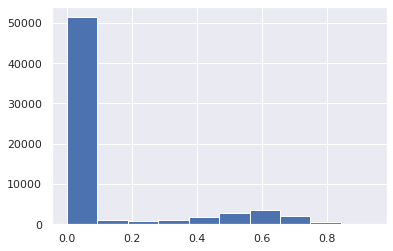

In [26]:
plt.hist(image[0, 40].reshape(-1))
plt.show()

In [27]:
# do we need to have equal D for all cases in batch?
# looks like yes
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
len(train_loader)

582

In [28]:
train_loader_iter = iter(train_loader)

In [29]:
x_batch, y_batch = next(train_loader_iter)
x_batch.shape, y_batch.shape

(torch.Size([1, 1, 48, 256, 256]), torch.Size([1]))

In [30]:
x_batch.max()

tensor(1.)

In [31]:
# y_batch = y_batch.long()
# y_batch = y_batch.type(torch.LongTensor)

In [32]:
y_batch, y_batch.dtype

(tensor([0]), torch.int64)

# Profiling

In [17]:
from torch.profiler import profile, record_function, ProfilerActivity

In [18]:
from utils import get_num_of_params

In [50]:
N, C, D, H, W = 5, 1, 32, 32, 32
X = torch.randn(N, C, D, H, W)

In [49]:
model = Simple3DNet()

In [33]:
get_num_of_params(model)

1107905

In [22]:
torch.__version__

'1.9.0+cu102'

In [51]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(X)

In [52]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         1.18%       2.844ms        99.98%     241.917ms     241.917ms             1  
                     aten::conv3d         0.02%      37.000us        64.56%     156.219ms      52.073ms             3  
                aten::convolution         0.01%      34.000us        64.55%     156.182ms      52.061ms             3  
               aten::_convolution         0.03%      68.000us        64.54%     156.148ms      52.049ms             3  
         aten::mkldnn_convolution        64.35%     155.709ms        64.51%     156.080ms      52.027ms             3  
                 aten::max_pool3d       

In [29]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         3.03%      13.457ms        99.99%     443.455ms     443.455ms             1                                                                                []  
                     aten::conv3d         0.01%      25.000us        39.04%     173.136ms     173.136ms             1                        [[5, 1, 32, 32, 32], [64, 1, 3, 3, 3], [], [], [], 

In [61]:
# model = Simple3DNet().to(device)
# X = torch.randn(N, C, D, H, W).to(device)

model = Simple3DNet()
X = torch.randn(N, C, D, H, W)

In [62]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True
) as prof:
    with record_function("model_inference"):
        model(X)

In [63]:
# cpu_memory_usage

# cuda_time_total

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::clamp_min         5.34%      12.196ms        10.67%      24.356ms       4.059ms     105.00 Mb      52.50 Mb             6  
                      aten::empty         0.05%     116.000us         0.05%     116.000us       7.733us      52.50 Mb      52.50 Mb            15  
                     aten::conv3d         0.01%      29.000us        63.12%     144.145ms      48.048ms      52.50 Mb           0 b             3  
                aten::convolution         0.01%      32.000us        63.11%     144.116ms      48.039ms      52.

# Memory management

In [ ]:
def display_memory():
    torch.cuda.empty_cache()
    memory = torch.cuda.memory_allocated(device)
    print("{:.3f} GB".format(memory / 1024 ** 3))

In [43]:
display_memory()
X = torch.randn(1, 1, 128, 256, 256).to(device)
display_memory() # 256*256*256*4 / 1024 ** 3

0.013 GB
0.044 GB


In [74]:
%%time

display_memory()

model = Simple3DNet().to(device)
output = model(X)
print(output.shape)

display_memory()
del output
display_memory()

0.060 GB
torch.Size([1, 1])
1.964 GB
0.061 GB
CPU times: user 828 ms, sys: 188 ms, total: 1.02 s
Wall time: 1.02 s


In [98]:
# when we can do this during training?
# we do not need actually?
# del output

# Single model path

In [ ]:
model = Simple3DNet()

In [ ]:
%%time
N, C, D, H, W = 5, 1, 26, 256, 256
X = torch.randn(N, C, D, H, W)

output = model(X)
output.shape

CPU times: user 30.1 s, sys: 5.37 s, total: 35.5 s
Wall time: 34.9 s


torch.Size([5, 1])

In [ ]:
# del output

In [ ]:
%%time
output = model(x_batch)
output.shape

CPU times: user 18.6 s, sys: 3.6 s, total: 22.2 s
Wall time: 22.2 s


In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# output.dtype, y_batch.dtype

In [ ]:
y_batch = y_batch.type_as(output)
loss = criterion(output.squeeze(1), y_batch)

In [ ]:
loss

tensor(0.6732, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [ ]:
output, y_batch

(tensor([[0.0402]], grad_fn=<AddmmBackward>), tensor([1.]))

In [ ]:
output.shape, y_batch.shape

(torch.Size([1, 1]), torch.Size([1]))

In [ ]:
indices = torch.argmax(output, 1)
indices

tensor([0])

In [ ]:
y_pred = (output > 0)
# y_pred = torch.sigmoid(output)
# y_pred = y_pred > 0.5
y_pred.shape

torch.Size([1, 1])

In [ ]:
correct_samples = torch.sum(y_pred == y_batch)
correct_samples

tensor(1)

In [ ]:
y_batch.shape[0]

1

# Overfit small dataset

In [34]:
display_memory()

0.000 GB


In [60]:
train_number = 8
train_df = train_labels_df[(train_labels_df['FLAIR_count']<30) & (train_labels_df['FLAIR_count'] != 0)]
train_df = train_df.sample(frac=1).reset_index(drop=True).head(train_number)
train_df

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,294,1,27,29,29,30
1,104,0,25,21,21,21
2,795,1,24,23,25,23
3,106,1,25,25,25,25
4,589,0,16,19,15,15
5,216,0,28,139,139,28
6,791,1,27,27,27,28
7,111,0,21,21,148,21


In [61]:
train_dataset = Image3DDataset(train_df, IMG_PATH_TRAIN, get_train_transform(IMG_SIZE))
len(train_dataset)

8

In [62]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
len(train_loader)

8

In [39]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [80]:
max_iter = 200
print_every = 10

seed_everything(seed)

model = Simple3DNet().to(device)

learning_rate = 0.001
weight_decay = 0

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay,
    nesterov=True
)

loss_meter, score_meter = train_num_iter(
    model, device, train_loader, criterion, optimizer,
    max_iter=max_iter,
    print_every=print_every
)

[train] iter:    0, loss = 0.69268, score = 1.00000, batch: torch.Size([1, 1, 16, 256, 256]), time: 0:00:00
[train] iter:   10, loss = 0.69689, score = 0.36364, batch: torch.Size([1, 1, 25, 256, 256]), time: 0:00:01
[train] iter:   20, loss = 0.69725, score = 0.33333, batch: torch.Size([1, 1, 27, 256, 256]), time: 0:00:01
[train] iter:   30, loss = 0.69733, score = 0.38710, batch: torch.Size([1, 1, 24, 256, 256]), time: 0:00:01
[train] iter:   40, loss = 0.69755, score = 0.39024, batch: torch.Size([1, 1, 25, 256, 256]), time: 0:00:01
[train] iter:   50, loss = 0.69684, score = 0.41176, batch: torch.Size([1, 1, 16, 256, 256]), time: 0:00:00
[train] iter:   60, loss = 0.69708, score = 0.42623, batch: torch.Size([1, 1, 16, 256, 256]), time: 0:00:00
[train] iter:   70, loss = 0.69599, score = 0.45070, batch: torch.Size([1, 1, 24, 256, 256]), time: 0:00:01
[train] iter:   80, loss = 0.69566, score = 0.44444, batch: torch.Size([1, 1, 25, 256, 256]), time: 0:00:01
[train] iter:   90, loss = 0

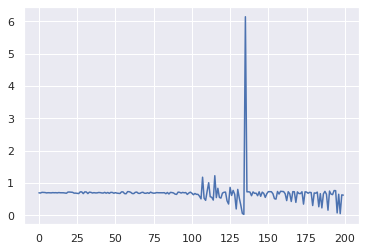

In [81]:
plt.plot(loss_meter.history)

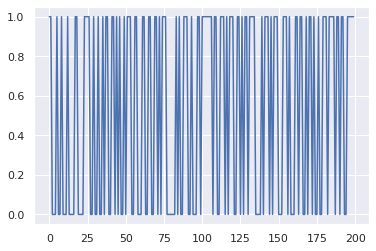

In [82]:
plt.plot(score_meter.history)

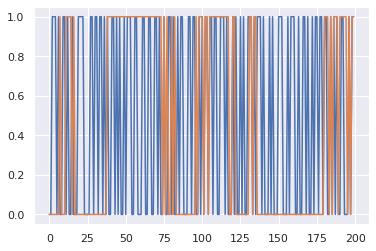

In [84]:
plt.plot(score_meter.ground_truth)
plt.plot(score_meter.predictions)

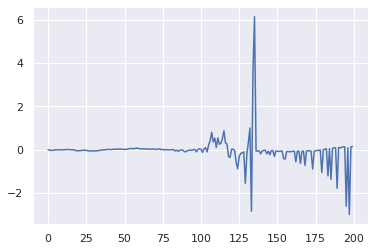

In [85]:
plt.plot(score_meter.outputs)